---
# **1 - Problemformalisierung, Zustandsraum**
---

---
## **1.1 - Problemformalisierung**
---

### **Zustände**

Auf einer Seite können 0 - 3 Elben, sowie 0 - 3 Orks sein (die Anzahl auf der anderen Seite ergibt sich in der Differenz), das Pferd kann Rechts oder Links sein. Ein Zustand kann also formalisiert werden als:


### \begin{equation}
Zustand = ((Elben L, Orks L), (Elben R, Orks R), Pferd)
\end{equation}


$(Elben R, Orks R)$ ist nur vom Tupel der anderen Seite abhängig (bzw. andersum), es brauchen also nur die 4 möglichen Werte für $Elben L$, die 4 für $Orks L$ und die 2 für die Position des Pferds berücksichtigt werden. Davon sind noch 12 ungültige Zustände abzuziehen für die Bedingung *"mehr Elben als Orks"*. Damit ergeben sich an (erlaubten) Zuständen insgesamt:


### \begin{equation}
4 \space × \space 4 \space × \space 2 - 12 = 20
\end{equation}


---
### **Aktionen**

es können jeweils Kombinationen aus 1 - 2 Kreaturen (Elben / Orks) bewegt werden, sowohl von Links nach Rechts, als auch umgekehrt:

*   (1, 0, L) - Elb nach Links bringen
*   (1, 0, R) - Elb nach Rechts bewegen
*   (0, 1, L) - Ork nach Links bewegen
*   (0, 1, R) - Ork nach Rechts bewegen
*   (2, 0, L) - 2 Elben nach Links bewegen
*   (2, 0, R) - 2 Elben nach Rechts bewegen
*   (0, 2, L) - 2 Orks nach Links bewegen
*   (0, 2, R) - 2 Orks nach Rechts bewegen
*   (1, 1, L) - Elb + Ork nach Links bewegen
*   (1, 1, R) - Elb + Ork nach Rechts bewegen

---
### **Start- und Endzustand**


zunächst sind alle Elben, Orks sowie das Pferd auf einer Seite (hier als *Links* bezeichnet):

### \begin{equation}
START = ((3,3), \space (0,0), \space L)
\end{equation}


Ziel ist, alle Orks und Elben auf die andere Seite zu bringen (hier als *Rechts* bezeichnet), das Pferd ist demnach notwendigerweise auch auf der anderen Seite:

### \begin{equation}
ZIEL = ((0,0), \space (3,3), \space R)
\end{equation}

---
## **1.2 - Problemgraph**
---

der Problemgraph zeigt nur von *START* zu erreichenden Zustände - 3 isolierte Zustände erfüllen zwar die Bedingung *"nicht mer Orks als Elben je Seite"*, sind aber vom restlichen Grafen isoliert, daher nicht dargestellt:

* ((3,3), (0,0), R) — Pferd darf nicht leer laufen
* ((3,0), (0,3), L) - Elben dürfen nicht nach R bewegt werden (sonst Elben < Orks)
* ((0,3), (3,0), R) - Elben dürfen nicht nach L bewegt werden (sonst Elben < Orks)

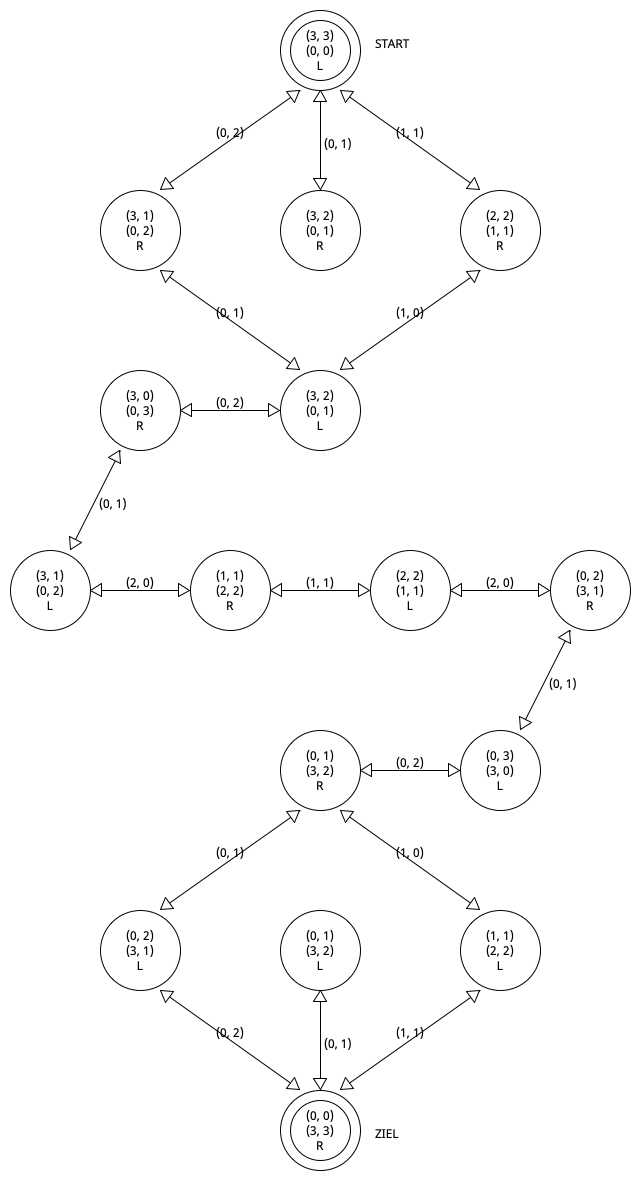

---
# **2 - Suchverfahren**
---

---
## **2.1 - Implementierung**
---

**Problemgraph:**

In [216]:
# ist der Graph mit Adjazenten-Liste 'edges' ungerichtet?
def is_undirected(edges):
  # alle Knoten durchgehen
  for node, neighbor_list in edges.items():
    # Liste der Nachbarn von 'node' durchgehen:
    for neighbor, weight in neighbor_list.items():
      # ist Kante 'node' -> 'neighbor' auch andersrum verzeichnet?
      # ('neighbor' -> 'node', dh. 'node' ist Nachbar von 'neighbor')
      if (edges.get(neighbor) == None):
        return False
      if (edges.get(neighbor).get(node) != weight):
        return False
  # alle Kanten symmetrisch -> Graph ungerichtet
  return True


# ungerichteter, gewichteter Graph
class Graph:
  # Graph mit Adjazenten-Liste 'edges' erstellen
  def __init__(self, edges):
    if not is_undirected(edges):
      raise Exception

    self.edges = edges

  # alle Nachbar-Knoten von 'name'
  def neighbors(self, name):
    return self.edges.get(name)


# Ajazenten-Liste der gewichteten Kanten für die Knoten im Graphen
graph = Graph({
  "Frankfurt":  { "Mannheim": 85, "Würzburg": 217, "Kassel": 173 },
  "Mannheim":   { "Frankfurt": 85, "Karlsruhe": 80 },
  "Würzburg":   { "Frankfurt": 217, "Erfurt": 186, "Nürnberg": 103 },
  "Kassel":     { "Frankfurt": 173, "München": 502 },
  "Karlsruhe":  { "Mannheim": 80, "Augsburg": 250 },
  "Erfurt":     { "Würzburg": 186 },
  "Nürnberg":   { "Würzburg": 103, "Stuttgart": 183, "München": 167 },
  "Stuttgart":  { "Nürnberg": 183 },
  "Augsburg":   { "Karlsruhe": 250, "München": 84 },
  "München":    { "Augsburg": 84, "Nürnberg": 167, "Kassel": 502 }
})


**Suchbaum:**


In [217]:
# Pfad als String formattieren
def path_str(path):
  delimiter = " --> "
  path_strs = map(str, path)
  return delimiter.join(path_strs)


# Suchbaum-Knoten mit Zustand 'name' und Eltern-Knoten
class TreeNode:
  def __init__(self, name, parent=None, cost=0):
    self.name = name
    self.parent = parent
    self.cost = cost

  # Pfad für diesen Knoten
  def path(self):
    if (self.parent == None):
      return [ self.name ]
    else:
      return self.parent.path() + [ self.name ]

  # String-Darstellung (-> 'name')
  def __str__(self):
    return self.name

  def __repr__(self):
    return self.name

  # anhand 'name' vergleichen (lexigrafisch)
  def __eq__(self, other):
    return isinstance(other, TreeNode) and (self.name == other.name)

  def __lt__(self, other):
    return isinstance(other, TreeNode) and (self.name < other.name)


### **Breitensuche (Graph-Search)**

In [218]:
from collections import deque


# Kürzesten Weg zu Zustand 'target' im Graphen 'graph'
# mittels BFS (als Graph-Search) suchen
def bfs(graph, start, target):
  # ist 'start' bereits das Ziel?
  if (start == target):
    return TreeNode(start)

  # FIFO-Queue stellt korrekte Reihenfolge (BFS) sicher
  queue = deque([ TreeNode(start) ])
  # Graph-Search-Variante verlangt Prüfung
  # auf bereits ereichte Zustände (bzw Schleifen)
  reached = { start }

  # initiale Queue ausgeben
  print(f"initial:\t\t{list(queue)}")
  i = 1

  while queue:
    # nächstes Element aus Queue holen
    node = queue.popleft()

    # Nachfolger von 'node' durchgehen (lexigrafische Reihenfolge)
    for child in sorted(graph.neighbors(node.name).keys()):
      # Suchbaum-Eintrag für 'child' erstellen, Kosten pro Aktion stets 1
      cost = (node.cost + 1)
      child_node = TreeNode(name=child, parent=node, cost=cost)

      # vorgezogene Zielprüfung
      if (child == target):
        print(f"Schritt {i} ({node}):\t{list(queue)}   --> Ziel erreicht: {child_node}")
        return child_node

      # 'child' an Queue anhängen (sofern Zustand bisher nicht erreicht)
      if (child not in reached):
        reached.add(child)
        queue.append(child_node)

    # resultierende Queue ausgeben
    print(f"Schritt {i} ({node}):\t{list(queue)}")
    i += 1

  # Suche ohne Erfolg -> kein Pfad von 'start' zu 'target' möglich
  return None


# optimalen Pfad ermitteln
optimal = bfs(graph, start="Würzburg", target="München")

print("-" * 100)
print(f"Pfad:\t\t{path_str(optimal.path())}")
print(f"Kosten:\t\t{optimal.cost}")


initial:		[Würzburg]
Schritt 1 (Würzburg):	[Erfurt, Frankfurt, Nürnberg]
Schritt 2 (Erfurt):	[Frankfurt, Nürnberg]
Schritt 3 (Frankfurt):	[Nürnberg, Kassel, Mannheim]
Schritt 4 (Nürnberg):	[Kassel, Mannheim]   --> Ziel erreicht: München
----------------------------------------------------------------------------------------------------
Pfad:		Würzburg --> Nürnberg --> München
Kosten:		2


**Analyse:**
*   Hauptschleife wird durchlaufen: **4 mal**
*   im Maximum enthält die Queue: **3 Elemente**

---
### **Tiefensuche (Graph-Search)**
---

In [219]:
# Kürzesten Weg zu Zustand 'target' im Graphen 'graph'
# mittels DFS (als Graph-Search) suchen
def dfs(graph, start, target):
  # ist 'start' bereits das Ziel?
  if (start == target):
    return TreeNode(start)

  # LIFO-Stack stellt korrekte Reihenfolge (DFS) sicher
  stack = [ TreeNode(start) ]

  # Graph-Search-Variante verlangt Prüfung
  # auf bereits ereichte Zustände (bzw Schleifen)
  reached = { start }

  # initialen Stack ausgeben
  print(f"initial:\t\t{stack}")
  i = 1

  while stack:
    # jeweils nächstes Element aus Stack holen
    node = stack.pop()

    # Nachfolger von 'node' durchgehen (lexigrafische Reihenfolge
    # -> bei Stack andersum hinzufügen, letztes Element wird zuerst entnommen)
    for child in sorted(graph.neighbors(node.name).keys(), reverse=True):
      # Suchbaum-Eintrag für 'child' erstellen, Kosten pro Aktion stets 1
      cost = (node.cost + 1)
      child_node = TreeNode(name=child, parent=node, cost=cost)

      # vorgezogene Zielprüfung
      if (child == target):
        print(f"Schritt {i} ({node}):\t{stack}   --> Ziel erreicht: {child_node}")
        return child_node

      # 'child' an Queue anhängen (sofern Zustand bisher nicht erreicht)
      if (child not in reached):
        reached.add(child)
        stack.append(child_node)

    # resultierenden Stack ausgeben
    print(f"Schritt {i} ({node}):\t{stack}")
    i += 1

  # Suche ohne Erfolg
  return None


# optimalen Pfad ermitteln
optimal = dfs(graph, start="Würzburg", target="München")

print("-" * 100)
print(f"Pfad:\t\t{path_str(optimal.path())}")
print(f"Kosten:\t\t{optimal.cost}")


initial:		[Würzburg]
Schritt 1 (Würzburg):	[Nürnberg, Frankfurt, Erfurt]
Schritt 2 (Erfurt):	[Nürnberg, Frankfurt]
Schritt 3 (Frankfurt):	[Nürnberg, Mannheim, Kassel]
Schritt 4 (Kassel):	[Nürnberg, Mannheim]   --> Ziel erreicht: München
----------------------------------------------------------------------------------------------------
Pfad:		Würzburg --> Frankfurt --> Kassel --> München
Kosten:		3


**Analyse:**
*   Hauptschleife wird durchlaufen: **4 mal**
*   im Maximum enthält der Stack: **3 Elemente**

---
### **A\*-Suche (Tree-Search)**

**Vorgegebene Heuristik:**

In [220]:
# Restkostenschätzung (unzulässig)
heuristic_illegal = {
  "Frankfurt":  100,
  "Mannheim":   200,
  "Würzburg":   170,
  "Kassel":     460,
  "Karlsruhe":  10,
  "Erfurt":     400,
  "Nürnberg":   537,
  "Stuttgart":  300,
  "Augsburg":   0,
  "München":    0
}

In [221]:
import heapq as hq


# kommt 'node' bereits früher in dessen Suchbaum vor?
def is_cycle(node):
  path = node.path()
  # 'node' taucht mehrfach auf -> Zyklus
  return (path.count(node.name) > 1)


# Kürzesten Weg zu Zustand 'target' im Graphen 'graph'
# mittels A* (als Tree-Search) suchen
def a_star(graph, start, target, h):
  # ist 'start' bereits das Ziel?
  if (start == target):
    return TreeNode(start)

  # Priority-Queue sortiert nach Kosten (primär) und Name (sekundär)
  prio_queue = [ (h[start], TreeNode(start)) ]

  # initiale Prio-Queue ausgeben
  print(f"initial:\t\t{prio_queue}")
  i = 1

  while prio_queue:
    # jeweils nächstes Element aus Prio-Queue holen
    _, node = prio_queue.pop(0)

    # Zielprüfung
    if (node.name == target):
      print(f"Schritt {i} ({node}):\t{prio_queue}   --> Ziel erreicht: {node}")
      return node

    # Nachfolger von 'node' durchgehen
    for child, path_cost in graph.neighbors(node.name).items():
      # Suchbaum-Eintrag für 'child' erstellen, mit Kosten des Pfads
      g_cost = (node.cost + path_cost)
      child_node = TreeNode(name=child, parent=node, cost=g_cost)

      # 'child' an Prio-Queue anhängen (sofern kein Zyklus)
      if not is_cycle(child_node):
        # Kosten f (von 'child') = Pfadkosten + Heuristik
        f_cost = g_cost + h[child]
        prio_queue.append((f_cost, child_node))

    # sortieren - primär nach Kosten f, sekundär nach Name (lexigrafisch)
    prio_queue.sort()

    # resultierende Prio-Queue ausgeben
    print(f"Schritt {i} ({node}):\t{prio_queue}")
    i += 1

  # Suche ohne Erfolg
  return None


# optimalen Pfad ermitteln
optimal = a_star(graph, start="Würzburg", target="München", h=heuristic_illegal)

print("-" * 100)
print(f"Pfad:\t\t{path_str(optimal.path())}")
print(f"Kosten:\t\t{optimal.cost}")


initial:		[(170, Würzburg)]
Schritt 1 (Würzburg):	[(317, Frankfurt), (586, Erfurt), (640, Nürnberg)]
Schritt 2 (Frankfurt):	[(502, Mannheim), (586, Erfurt), (640, Nürnberg), (850, Kassel)]
Schritt 3 (Mannheim):	[(392, Karlsruhe), (586, Erfurt), (640, Nürnberg), (850, Kassel)]
Schritt 4 (Karlsruhe):	[(586, Erfurt), (632, Augsburg), (640, Nürnberg), (850, Kassel)]
Schritt 5 (Erfurt):	[(632, Augsburg), (640, Nürnberg), (850, Kassel)]
Schritt 6 (Augsburg):	[(640, Nürnberg), (716, München), (850, Kassel)]
Schritt 7 (Nürnberg):	[(270, München), (586, Stuttgart), (716, München), (850, Kassel)]
Schritt 8 (München):	[(586, Stuttgart), (716, München), (850, Kassel)]   --> Ziel erreicht: München
----------------------------------------------------------------------------------------------------
Pfad:		Würzburg --> Nürnberg --> München
Kosten:		270


**Analyse:**
*   Hauptschleife wird durchlaufen: **8 mal**
*   im Maximum enthält die Prioritäts-Queue: **4 Elemente**

---

## **2.2 - Zulässigkeit der Heuristik**

---

### **Definition: *Zulässigkeit***

>
> für alle Knoten n des Graphen muss gelten:
>
> # \begin{equation}
> \forall n \in 𝐆: \space h(n) \space \space \le \space \space h^*(n)
> \end{equation}
>
> $$
> \begin{aligned}
> h(n) &:= \text{Restkostenabschätzung für Knoten } n \\
> h^*(n) &:= \text{Optimale Kosten zum Ziel von } n \\
> \mathbf{G} &:= \text{Menge aller Knoten des Problemgraphen}
> \end{aligned}
> $$

---
### **unzulässige Restkostenabschätzung**

Heuristik für $Nürnberg$:


#### \begin{equation}
h(Nürnberg) \space \space := \space \space 537
\end{equation}


optimale Pfadkosten von $Nürnberg$:

#### \begin{equation}
h^*(Nürnberg) \space \space := \space \space 167 \\
\end{equation}


entgegenen der Anforderung für eine *Zulässige Heuristik* ergibt sich somit:

#### \begin{equation}
h(Nürnberg) \space \space \not \le \space \space h^*(Nürnberg) \\
\end{equation}


damit zeigt sich die Unzulässigkeit der Heuristik als:

# \begin{equation}
\exists n \in 𝐆: \space
\space h(n) \space \space \not \le \space \space h^*(n)
\end{equation}


---

### **korrigierte Heuristik**

korrigierte Restkostenabschätzung für $Nürnberg$:


#### \begin{equation}
h(Nürnberg) \space \space := \space \space 167 \\
\end{equation}


somit ist die Anforderung wieder erfüllt, weil gilt:

#### \begin{equation}
h(Nürnberg) \space \space \le \space \space h^*(Nürnberg) \\
\end{equation}

In [222]:
# Restkostenschätzung (zulässig)
heuristic_legal = {
  "Frankfurt":  100,
  "Mannheim":   200,
  "Würzburg":   170,
  "Kassel":     460,
  "Karlsruhe":  10,
  "Erfurt":     400,
  "Nürnberg":   167,
  "Stuttgart":  300,
  "Augsburg":   0,
  "München":    0
}

**A\* mit korrigierter Heuristik:**

In [223]:
# optimalen Pfad ermitteln
optimal = a_star(graph, start="Würzburg", target="München", h=heuristic_legal)

print("-" * 100)
print(f"Pfad:\t\t{path_str(optimal.path())}")
print(f"Kosten:\t\t{optimal.cost}")


initial:		[(170, Würzburg)]
Schritt 1 (Würzburg):	[(270, Nürnberg), (317, Frankfurt), (586, Erfurt)]
Schritt 2 (Nürnberg):	[(270, München), (317, Frankfurt), (586, Erfurt), (586, Stuttgart)]
Schritt 3 (München):	[(317, Frankfurt), (586, Erfurt), (586, Stuttgart)]   --> Ziel erreicht: München
----------------------------------------------------------------------------------------------------
Pfad:		Würzburg --> Nürnberg --> München
Kosten:		270


* **optimaler Pfad** auch mit unzulässiger Heuristik ermittelt

* aber: **weniger effizient** als mit zulässiger Heuristik (**8** Hauptschleifen-Iterationen statt **3**)

---
### **Hinweis zur Optimalität**

> Entgegen dem Beispiel ist eine unzulässige Heuristik im Allgemeinen natürlich nicht optimal:


Würde die Heuristik bspw. die Restkosten für *Nürnberg* um weitere **+76**, also mit **613** überschätzten (statt "nur" mit **537**), so wäre bei Schritt 7 der Umweg über *Augsburg* genommen worden (da in der Prioritäts-Queue dann Augsburg vor München kommen würde, beide mit **716** einsortiert).



---
# **3 - Dominanz**
---

### **Definition: *Dominierende Heuristik***
>
> wenn für (zulässige) Heuristiken $h_1(n)$ und $h_2(n)$ gilt:
>
> # \begin{equation}
> \forall n \in 𝐆: \space h_1(n) \space \space \ge \space \space h_2(n)
> \end{equation}
>
> $$
> \begin{aligned}
> \mathbf{G} &:= \text{Menge aller Knoten des Problemgraphen}
> \end{aligned} \\
> $$
>
> sagt man:
>
> ### \begin{aligned}
> \text{" Heuristik $h_1(n)$ dominiert Heuristik $h_2(n)$ "}
> \end{aligned}

---
### **Auswirkungen**

Da beide Heuristiken *zulässig* sind, und die dominierende Statistik kleinere oder gleiche Restwerte schätzt, gilt:

# \begin{equation}
\forall n \in 𝐆: \space h_2(n) \space \space
\le \space \space h_1(n) \space \space
\le \space \space h^*(n)
\end{equation}

$$
\begin{aligned}
\mathbf{G} &:= \text{Menge aller Knoten des Problemgraphen}
\end{aligned} \\
$$


$⇒$ Die dominierende Heuristik $h_1(n)$ kommt näher als $h_2(n)$ oder gleich nahe an die echten Restwerte $h^*(n)$ ran.


> Mit größeren Restwertschätzungen rutschen suboptimale Pfade in der Prioritäten-Liste stärker nach hinten als der optimaler Pfad - weniger Knoten müssen für die optimale Lösung untersucht werden.



---
### **Beispiel**

Ein triviales Beispiel sind folgende Heuristiken:

$$
\begin{aligned}
h_1(n) &:= \text{Luftlinie von n bis zum Ziel} \\
h_2(n) &:= 0
\end{aligned} \\
$$


Für den Problemgraphen zur kürzesteten Strecke zwischen 2 Orten sind beide Heuristiken zulässig und $h_1(n)$ dominiert $h_2(n)$. Mit der Heuristik $h_2(n)$ reduziert sich der Suchalgortihmus auf *Dijkstra* / *Uniform-Cost-Search*. *A\** ist bekanntermaßen effizienter als *Dijkstra* / *Uniform-Cost-Search* (oder gleich effizient) - dies zeigt sich anhand der Dominanz der Heuristik.


---
# **4 - Beweis: Optimalität von A\***
---

### **Annahmen** ###

Es gebe einen Problemgraphen mit genau einem Start-Zustand, min. einem Ziel-Knoten $G$, und einer zulässige Heuristik $h(n)$. Es gebe genau einen optimalen Pfad mit Kosten $C^*$.

---
### **Wiederspruchsbeweis**

Angenommen **A\*** liefere im Ergebnis einen Pfad mit Kosten $C$, der nicht optimal ist, dh. es gilt:

$$
\begin{aligned}
C \gt C^*
\end{aligned} \\
$$


die Kosten dieses subotpimalen Pfads $C$ ergeben sich als reale Pfadkosten bis zum Zielknoten $G$:

$$
\begin{equation}
C = g(G)
\end{equation} \\
$$


Da $h(n)$ eine zulässige Heuristik ist ($G$ ist ja Ziel-Knoten), folgt:

$$
\begin{aligned}
h(G) &= 0 \\
f(G) &= g(G) + h(G) = g(G) \\ \\
C &= g(G) = f(G)
\end{aligned} \\
$$


Betrachtet man den eig. optimalen Pfad mit Kosten $C^*$, so muss min. 1 Knoten $i$ dieses Pfads bisher nicht erkundet worden sein - ansonsten wäre der optimale Pfad bzw. Ziel-Knoten vorn in der Prioritäts-Liste, der suboptimale Ziel-Knoten $G$ wäre dann nicht als Ergebnis resultiert.

Da statt diesem Knoten $i$ aber der Ziel-Knoten $G$ erkundet wurde, muss dieser hinter letzterem in der Prioritäts-Liste liegen:

$$
\begin{aligned}
f(i) \gt f(G) = C > C^* \\
\end{aligned} \\
$$


Für die Kosten $f(n)$ gilt ja:

$$
\begin{aligned}
f(n) = g(n) + h(n) \\
\end{aligned} \\
$$


Da $i$ auf dem optimalen Pfad liegt sind die bisherigen Pfadkosten $g(i)$ hier optimal, die optimalen Pfadkosten sein (auch allgemein) als $g^*(n)$ eingeführt:

$$
\begin{aligned}
f(i) = g^*(i) + h(i) \\
\end{aligned} \\
$$


Mit der Annahme für $h(n)$ als zulässige Heurisitik gilt für diese defintionsgemäß (wobei $h^*(n)$ die tatsächlichen Restkosten sind):

$$
\begin{aligned}
h(n) \le h^*(n) \\
\end{aligned} \\
$$


Daraus folgt dann:

$$
\begin{aligned}
f(i) = g^*(i) + h(i) \le g^*(n) + h^*(n) \\
\end{aligned} \\
$$


Da für die optimalen Kosten $C^*$ gilt:


$$
\begin{aligned}
C^* = g^*(n) + h^*(n) \\
\end{aligned} \\
$$


Folgt zuletzt nun:

$$
\begin{aligned}
f(i) \le C^*
\end{aligned} \\
$$


im Widerspruch zu (siehe oben):

$$
\begin{aligned}
f(i) > C^* \\
\end{aligned} \\
$$


> ### ⇒ mit diesem Widerspruch zeigt sich: *A\** kann keinen suboptimalen Pfad $C$ liefern, dh. *A\** ist kosten-optimal (bei zulässiger Heuristik)